In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, 3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16*5*5, 64), nn.ReLU(), nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 16*5*5)
        return self.fc(x)


In [3]:
def histogram_weights(model, title):
    weights = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights.append(param.detach().cpu().view(-1))
    if not weights:
        print(f"[INFO] Aucun poids à afficher pour : {title}")
        return
    all_weights = torch.cat(weights)
    plt.hist(all_weights.numpy(), bins=50)
    plt.title(title)
    plt.xlabel("Valeur des poids")
    plt.ylabel("Fréquence")
    plt.grid(True)
    plt.show()


In [4]:
def train_and_quantize(model, trainloader, epochs=3):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    losses = []

    for epoch in range(epochs):
        total_loss = 0.0
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(trainloader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
        losses.append(avg_loss)

    # Perte
    plt.plot(losses, marker='o')
    plt.title("Loss avant quantization")
    plt.xlabel("Époques")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

    # Avant quantization
    histogram_weights(model, "Poids AVANT Quantization")

    # Quantization dynamique
    model.cpu()
    model_quantized = torch.quantization.quantize_dynamic(
        model, {nn.Linear}, dtype=torch.qint8
    )

    # Après quantization
    histogram_weights(model_quantized, "Poids APRÈS Quantization")


Epoch 1, Loss: 0.2766
Epoch 2, Loss: 0.0812
Epoch 3, Loss: 0.0576


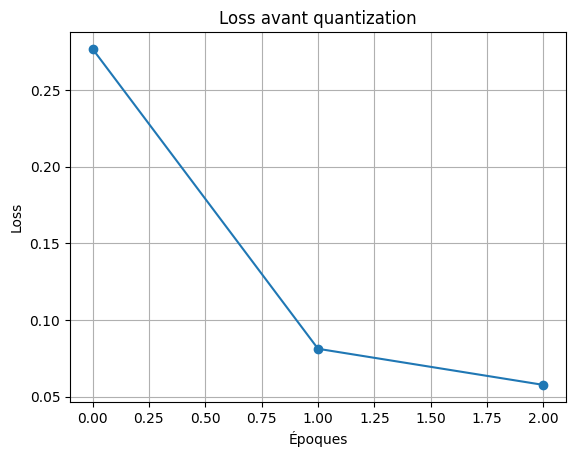

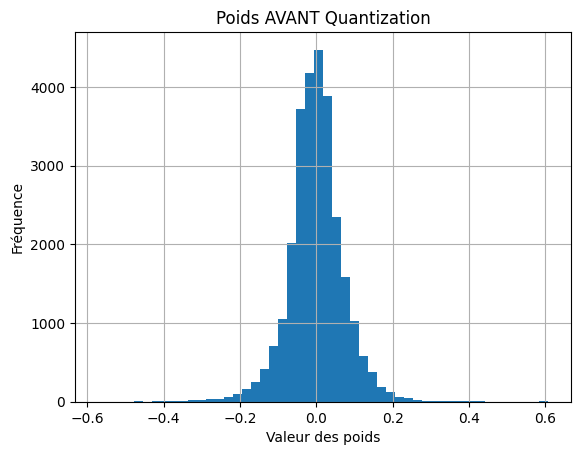

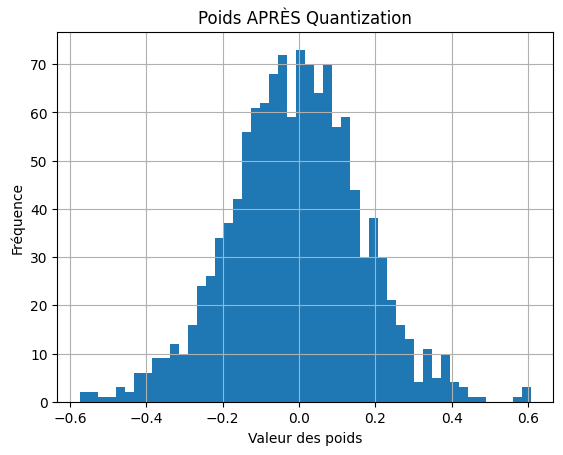

In [5]:
model = SimpleCNN().to(device)
train_and_quantize(model, trainloader)
